# Using Ring Deconvolution Microscopy (RDM)

This is a notebook which will walk you through basics of rdmpy.

Interested in some background on these methods? Check out the [paper](https://arxiv.org/abs/2206.08928).

The data we use in this notebook comes from the [UCLA Miniscope](http://miniscope.org/index.php/Main_Page).


## Setup

Here we import some necessary packages for the demo, including the star of the show: rdmpy

In [1]:
import rdmpy

# here are some basics we will need for the demo
import torch
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import resize
from PIL import Image

# Fill this in according to your computer, we highly recommend using a GPU.
# We needed ~20GB of GPU memory to run at full resolution.
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
    
print('Using ' +str(device) + ' for computation')

Using cuda:0 for computation


# # Calibration

The first step in the RDM pipeline is to calibrate your microscope. This is very similar to measuring a point spread function for deconvolution. The only difference is now you take a single image of randomly-placed point sources. We visualize one such calibration image from the Miniscope in the cell below. 

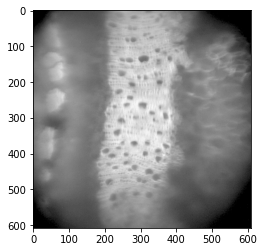

In [8]:
#calibration_image = np.array(Image.open('/home/alingold/20231219_miniscope/miniscopeDeviceName_2023_12_19_15_08_49.png'))
#calibration_image = np.array(Image.open('/home/alingold/20231214_miniscope/final.jpg'))
#calibration_image = np.array(Image.open('/home/alingold/20231219_miniscope/frame_ave.png'))
#calibration_image = np.array(Image.open('/home/alingold/20231219_miniscope/miniscopeDeviceName_2023_12_19_14_57_13.png'))
#calibration_image = np.array(Image.open('/home/alingold/20231219_miniscope/miniscopeDeviceName_2023_12_19_15_08_12.png'))
#calibration_image = np.array(Image.open('/home/alingold/20231219_miniscope/miniscopeDeviceName_2023_12_19_14_59_42.png'))
#calibration_image = np.array(Image.open('/home/alingold/20231219_miniscope/miniscopeDeviceName_2023_12_19_15_06_26.png'))
#calibration_image = np.array(Image.open('/home/alingold/20231219_miniscope/miniscopeDeviceName_2023_12_19_15_05_22.png'))
#calibration_image = np.array(Image.open('/home/alingold/20231227_miniscope/dark_subtract.png'))
#calibration_image = np.array(Image.open('/home/alingold/20231227_miniscope/miniscopeDeviceName_2023_12_27_12_27_19.png'))
#calibration_image = np.array(Image.open('/home/alingold/20231228_miniscope/dark_subtract.png'))
#calibration_image = np.array(Image.open('/home/alingold/20231228_miniscope/miniscopeDeviceName_2023_12_28_15_32_21.png'))
#calibration_image = np.array(Image.open('/media/alingold/MenonLab/20230109_miniscope/averaged_corrected_bead.png'))
#calibration_image = np.array(Image.open('/media/alingold/MenonLab/20230109_miniscope/averaged_dark_sub_bead.png'))
#calibration_image = np.array(Image.open('/media/alingold/MenonLab/20230109_miniscope/Bead/miniscopeDeviceName_2024_01_09_13_31_10.png'))
#calibration_image = np.array(Image.open('/media/alingold/MenonLab/20230109_miniscope/averaged_dark_sub_Bead_Cardboard_0.2_noThreshold.png'))
calibration_image = np.array(Image.open('/home/alingold/rdmpy_20231220/output/20240119_single_crossSection/measurement.png'))



plt.imshow((calibration_image)**(1/2), cmap='gray')
io.imsave('output/calibration.png', calibration_image)
plt.show()

To calibrate, just input this image into the `calibrate` function. This will give back Seidel coefficients and synthetic PSFs. These characterize the system and can be directly used to deblur any image taken from the microscope.

fitting seidel coefficients...


  0%|          | 0/300 [00:00<?, ?it/s]/home/alingold/rdmpy_20231220/rdmpy/_src/seidel.py:149: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  [Fx, Fy] = torch.tensor(np.meshgrid(fx, fx), device=device)
100%|██████████| 300/300 [00:35<00:00,  8.48it/s]


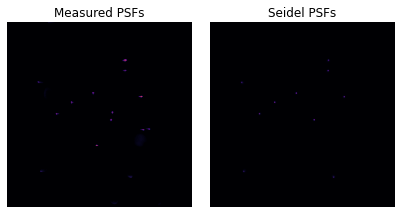

Fitted seidel coefficients: tensor([[0.3279],
        [0.4188],
        [0.1827],
        [0.5147],
        [0.0000],
        [0.0000]])
rendering PSFs...


100%|██████████| 608/608 [00:17<00:00, 34.93it/s]


In [3]:
dim = 608 # Pick this according to how big of an image you want to deblur.
seidel_coeffs, psf_data = rdmpy.calibrate(calibration_image, dim=dim, device=device)

# Deblurring

Having completed calibration, it's time to try out the various deblurring algorithms! We will start with ring deconvolution and DeepRD, and then try out some of the alternative methods. We will be deblurring an image of a tardigrade (shown below) taken with the Miniscope.  

In [4]:
# Set the path where you want to save your variables.
path = "/home/alingold/rdmpy_20231220/20231228_corrected.pt"

# Save the variables.
def save_variables(seidel_coeffs, psf_data, path):
    torch.save({'seidel_coeffs': seidel_coeffs, 'psf_data': psf_data}, path)

# Example use: 
    
save_variables(seidel_coeffs, psf_data, path)

In [1]:
import rdmpy

# here are some basics we will need for the demo
import torch
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import resize
from PIL import Image

# Fill this in according to your computer, we highly recommend using a GPU.
# We needed ~20GB of GPU memory to run at full resolution.
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
    
print('Using ' +str(device) + ' for computation')

# Load the variables.
def load_variables(path):
    loaded_data = torch.load(path)
    return loaded_data['seidel_coeffs'], loaded_data['psf_data']

# Example use:
# Set the path where you want to save your variables.
path = "/home/alingold/rdmpy_20231220/20240109_single.pt" # this one for plants
#path = "/home/alingold/rdmpy_20231220/20240112_Dark_sub_noThreshold.pt"
#path = "/home/alingold/rdmpy_20231220/20240112_Cardboard.pt"
#path = "/home/alingold/rdmpy_20231220/20231228_single.pt" #this one for USAF
#path = '/home/alingold/rdmpy_20231220/20231228_corrected.pt'
#path = "/home/alingold/rdmpy_20231220/20231227_single.pt" # dense beads



seidel_coeffs, psf_data = load_variables(path)# Determine the correct angular dimension size from psf_roft
#print(seidel_coeffs.shape)
dim = 608

Using cuda:0 for computation


Converting RGBA to grayscale


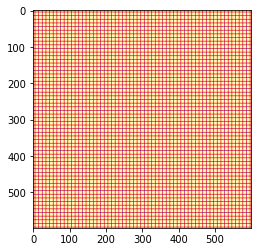

In [11]:
from skimage import io, color, img_as_ubyte
# A quick helper function to crop our image down to the correct size
def center_crop(img, des_shape, m_center=None):
    if m_center is None:
        m_center = (img.shape[0] // 2, img.shape[1] // 2)
    left, right, up, down = (
        m_center[1] - des_shape[1] // 2,
        m_center[1] + int(np.round(des_shape[1] / 2)),
        
        m_center[0] - des_shape[0] // 2,
        m_center[0] + int(np.round(des_shape[0] / 2)),
    )
    img = img[up:down, left:right]
    return img

# Add a small crop to help with edge artifacts
crop = 5

# read in the waterbear
#measurement = center_crop(io.imread('test_images/measurement.png')[:,:,0], [dim,dim])
#measurement = io.imread('/home/alingold/20231214_miniscope/USAF 9 GRID/miniscopeDeviceName_2023_12_14_15_24_10.png')
#measurement = io.imread('/home/alingold/20231219_miniscope/miniscopeDeviceName_2023_12_19_14_50_51.png') # most used USAF
#measurement = io.imread('/home/alingold/20231222_miniscope_plant/miniscopeDeviceName_2023_12_22_13_29_11.png') # Plant
#measurement = io.imread('/home/alingold/20231227_miniscope/miniscopeDeviceName_2023_12_27_12_35_26.png')
#measurement = io.imread('/home/alingold/20231228_miniscope/miniscopeDeviceName_2023_12_28_15_29_39.png')
#measurement = io.imread('/media/alingold/MenonLab/20230109_miniscope/miniscopeDeviceName_2024_01_09_13_25_01.png') 
#measurement = io.imread('/media/alingold/MenonLab/20230109_miniscope/averaged_corrected_measurement.png') 
#measurement = io.imread('/media/alingold/MenonLab/20230109_miniscope/Bead_measure/miniscopeDeviceName_2024_01_09_13_25_01.png') 
#measurement = io.imread('/media/alingold/MenonLab/20230116_plants/miniscopeDeviceName_2024_01_16_16_31_09.png') 
#measurement = io.imread('/media/alingold/MenonLab/20230109_miniscope/averaged_dark_sub_Plant_Cardboard_0.2_noThreshold.png') 
#measurement = io.imread('/media/alingold/MenonLab/20240119_miniscope/averaged_corrected_Plant_Ruler_0.01_noThreshold.png') 
#measurement = io.imread('/media/alingold/MenonLab/20240130_UV_timelapse/miniscopeDeviceName_2024_01_30_17_42_12.png') # new UV timelapse
#measurement = io.imread('/media/alingold/MenonLab/20240119_miniscope/zStack_CrossSection/miniscopeDeviceName_2024_01_19_11_03_58.png') # 0119 plant for comparison
#measurement = io.imread('/home/alingold/Downloads/combined_grid.png') # 0119 plant for comparison
#measurement = io.imread('/media/alingold/MenonLab/20240216_UV_cut/best_focus/5_for_fig/miniscopeDeviceName_2024_02_16_12_42_06.png') # 0119 plant for comparison
#measurement = io.imread('/home/alingold/pix2pix/results/plant_0bp_oldtest/test_latest/images/8845_fake_B.png') # 0119 plant for comparison
measurement = io.imread('/media/alingold/MenonLab/20230109_miniscope/Bead_measure/miniscopeDeviceName_2024_01_09_13_25_01.png')
measurement = io.imread('/media/alingold/MenonLab/20230109_miniscope/field_correction_20240312.png')
measurement = io.imread('/home/alingold/rdmpy_20231220/output/20240119_single_crossSection/measurement.png')
measurement = io.imread('/home/alingold/rdmpy_20231220/output/20240119_single/measurement.png')
#measurement = io.imread('/home/alingold/rdmpy_20231220/output/20240109_SingleUSAF_20231228_singleBeads (copy)/measurement.png')
#measurement = io.imread('/home/alingold/rdmpy_20231220/output/20231217_USAF_Grid_20231218_beads/measurement.png')
#measurement = io.imread('/home/alingold/rdmpy_20231220/output/20240331_USAF_grid_focus/USAF_9x9_Grid_focus.png')
#measurement = io.imread('/home/alingold/rdmpy_20231220/output/20240109_singleBead_singleUSAF/measurement.png')
measurement = io.imread('/home/alingold/rdmpy_20231220/output/20240331_USAF_grid_no_focus/USAF_9x9_Grid_no_focus.png')
measurement = io.imread('/home/alingold/Documents/Paper2Figs/grid_lines_10pix.png')


# Check if the image has more than one channel (grayscale should have only one)
if len(measurement.shape) == 3 and measurement.shape[2] == 4:
    # Assuming the image is RGBA, convert it to RGB first, then to grayscale
    measurement = color.rgb2gray(color.rgba2rgb(measurement))
    print('Converting RGBA to grayscale')
elif len(measurement.shape) == 3 and measurement.shape[2] == 3:
    # Convert RGB to grayscale
    measurement = color.rgb2gray(measurement)
    print('Converting RGB to grayscale')

if measurement.dtype != np.uint8:  # Check if not already 8-bit
    measurement = img_as_ubyte(measurement)  # Convert to 8-bit unsigned integers

plt.imshow(measurement[crop:-crop, crop:-crop], cmap='magma')
plt.show()
io.imsave('output/measurement.png', measurement)

Now, the moment we've been waiting for, it's time to use ring deconvolution! Just input the blurry image and psf data from calibration into `ring_deconvolve`.

100%|██████████| 300/300 [02:17<00:00,  2.18it/s]


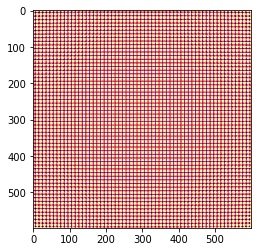

In [12]:
rd_recon = rdmpy.ring_deconvolve(measurement, psf_data, device=device)
plt.imshow(rd_recon[crop:-crop, crop:-crop], cmap='magma')
plt.show()
io.imsave('output/ring_deconvolve.png', (255 * rd_recon).astype(np.uint8))

In [3]:
import os
import numpy as np
from skimage import io, color, img_as_ubyte
from glob import glob
import re  # Regular expressions for sorting
import rdmpy  # Ensure rdmpy is imported for deconvolution

def natural_sort_key(s):
    """Helper function for sorting alphanumeric strings in a natural order"""
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def process_and_save_images(folder_path):
    crop = 5
    output_dir = 'output/longitudinal_timelapse_maxpro_30s'  # Main output directory for reconstructed images
    measurements_dir = os.path.join(output_dir, 'measurements')  # Directory for cropped measurement images
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(measurements_dir, exist_ok=True)  # Ensure the measurements directory exists

    image_formats = ['*.png', '*.jpg', '*.jpeg', '*.tif', '*.tiff']
    image_paths = []
    for image_format in image_formats:
        image_paths.extend(glob(os.path.join(folder_path, image_format)))

    image_paths.sort(key=natural_sort_key)  # Sort the image paths naturally

    for idx, image_path in enumerate(image_paths):
        measurement = io.imread(image_path)
        if len(measurement.shape) > 2:
            measurement = color.rgb2gray(measurement)
            print(f'Converting {os.path.basename(image_path)} to grayscale')
        measurement = img_as_ubyte(measurement)

        cropped_measurement = measurement[crop:-crop, crop:-crop]
        # Save cropped measurement images in the separate 'measurements' folder
        io.imsave(os.path.join(measurements_dir, f'{idx+1}_measurement.png'), cropped_measurement)

        # Assuming rdmpy.ring_deconvolve() is correctly imported and used
        l2_reg_value = 1e-5
        tv_reg_value = 1e-8

        # Make sure to define or import psf_data and device variables before using them here
        rd_recon = rdmpy.ring_deconvolve(
            measurement, 
            psf_data, 
            tv_reg=tv_reg_value, 
            l2_reg=l2_reg_value, 
            device=device
        )
        # Save the reconstructed images in the main output directory
        io.imsave(os.path.join(output_dir, f'{idx+1}.png'), (255 * rd_recon).astype(np.uint8))

# Example usage
folder_path = '/media/alingold/MenonLab/20240227_longitudinal_timelapses/30_sec/20240227_timelapse_30sec/maxpro_5'
process_and_save_images(folder_path)


Converting max_projection_30.png to grayscale


100%|██████████| 300/300 [02:17<00:00,  2.18it/s]


Converting max_projection_31.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.21it/s]


Converting max_projection_32.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_33.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_34.png to grayscale


100%|██████████| 300/300 [02:17<00:00,  2.19it/s]


Converting max_projection_35.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_36.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_37.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_38.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_39.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_40.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_41.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_42.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_43.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.19it/s]


Converting max_projection_44.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.21it/s]


Converting max_projection_45.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_46.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_47.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_48.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_49.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_50.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_51.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_52.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_53.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.21it/s]


Converting max_projection_54.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_55.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_56.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_57.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_58.png to grayscale


100%|██████████| 300/300 [02:17<00:00,  2.19it/s]


Converting max_projection_59.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_60.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_61.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_62.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_63.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_64.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.19it/s]


Converting max_projection_65.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_66.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_67.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_68.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_69.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_70.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.21it/s]


Converting max_projection_71.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_72.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_73.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_74.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_75.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_76.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_77.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_78.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_79.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_80.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_81.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.21it/s]


Converting max_projection_82.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_83.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_84.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_85.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_86.png to grayscale


100%|██████████| 300/300 [02:17<00:00,  2.19it/s]


Converting max_projection_87.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_88.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_89.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_90.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_91.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.21it/s]


Converting max_projection_92.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_93.png to grayscale


100%|██████████| 300/300 [02:13<00:00,  2.24it/s]


Converting max_projection_94.png to grayscale


100%|██████████| 300/300 [02:12<00:00,  2.27it/s]


Converting max_projection_95.png to grayscale


100%|██████████| 300/300 [02:13<00:00,  2.25it/s]


Converting max_projection_96.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_97.png to grayscale


100%|██████████| 300/300 [02:17<00:00,  2.19it/s]


Converting max_projection_98.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.19it/s]


Converting max_projection_99.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.19it/s]


Converting max_projection_100.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_101.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.21it/s]


Converting max_projection_102.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_103.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_104.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_105.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_106.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.19it/s]


Converting max_projection_107.png to grayscale


100%|██████████| 300/300 [02:17<00:00,  2.19it/s]


Converting max_projection_108.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_109.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_110.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_111.png to grayscale


100%|██████████| 300/300 [02:11<00:00,  2.28it/s]


In [5]:
import os
import numpy as np
from skimage import io, color, img_as_ubyte
from glob import glob
import re  # Regular expressions for sorting
import rdmpy  # Ensure rdmpy is imported for deconvolution

def natural_sort_key(s):
    """Helper function for sorting alphanumeric strings in a natural order"""
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def process_and_save_images(folder_path):
    crop = 5
    output_dir = 'output/rd_greenhouse_fungus'  # Main output directory for reconstructed images
    measurements_dir = os.path.join(output_dir, 'measurements')  # Directory for cropped measurement images
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(measurements_dir, exist_ok=True)  # Ensure the measurements directory exists

    image_formats = ['*.png', '*.jpg', '*.jpeg', '*.tif', '*.tiff']
    image_paths = []
    for image_format in image_formats:
        image_paths.extend(glob(os.path.join(folder_path, image_format)))

    image_paths.sort(key=natural_sort_key)  # Sort the image paths naturally

    for idx, image_path in enumerate(image_paths):
        measurement = io.imread(image_path)
        if len(measurement.shape) > 2:
            measurement = color.rgb2gray(measurement)
            print(f'Converting {os.path.basename(image_path)} to grayscale')
        measurement = img_as_ubyte(measurement)

        cropped_measurement = measurement[crop:-crop, crop:-crop]
        # Save cropped measurement images in the separate 'measurements' folder
        io.imsave(os.path.join(measurements_dir, f'{idx+1}_measurement.png'), cropped_measurement)

        # Assuming rdmpy.ring_deconvolve() is correctly imported and used
        l2_reg_value = 1e-5
        tv_reg_value = 1e-8

        # Make sure to define or import psf_data and device variables before using them here
        rd_recon = rdmpy.ring_deconvolve(
            measurement, 
            psf_data, 
            tv_reg=tv_reg_value, 
            l2_reg=l2_reg_value, 
            device=device
        )
        # Save the reconstructed images in the main output directory
        io.imsave(os.path.join(output_dir, f'{idx+1}.png'), (255 * rd_recon).astype(np.uint8))

# Example usage
folder_path = '/media/alingold/MenonLab/20240323_fungus/maxpro'
process_and_save_images(folder_path)


Converting max_projection_1.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_2.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_3.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_4.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_5.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_6.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_7.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_8.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_9.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_10.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_11.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_12.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_13.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_14.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_15.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_16.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_17.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_18.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_19.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_20.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_21.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_22.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_23.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_24.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_25.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_26.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_27.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_28.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_29.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_30.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_31.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_32.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_33.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_34.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_35.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.21it/s]


Converting max_projection_36.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_37.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_38.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_39.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_40.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_41.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_42.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_43.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_44.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_45.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_46.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_47.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_48.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_49.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_50.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_51.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_52.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_53.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_54.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_55.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_56.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_57.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_58.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_59.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_60.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_61.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_62.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_63.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_64.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_65.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_66.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_67.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_68.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_69.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_70.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_71.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_72.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_73.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_74.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_75.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_76.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_77.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_78.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_79.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_80.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_81.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_82.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_83.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_84.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_85.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_86.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_87.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_88.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_89.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_90.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_91.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_92.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_93.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_94.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_95.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_96.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_97.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_98.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_99.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_100.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_101.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_102.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_103.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_104.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_105.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_106.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_107.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_108.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_109.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_110.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_111.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_112.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_113.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_114.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_115.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_116.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_117.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.21it/s]


Converting max_projection_118.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_119.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_120.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_121.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_122.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_123.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.21it/s]


Converting max_projection_124.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_125.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_126.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_127.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_128.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_129.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_130.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_131.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_132.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_133.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_134.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_135.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_136.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_137.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_138.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_139.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_140.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_141.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_142.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_143.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_144.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_145.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_146.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_147.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_148.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_149.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_150.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_151.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_152.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_153.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_154.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_155.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_156.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_157.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_158.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_159.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_160.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_161.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_162.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_163.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_164.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_165.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_166.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_167.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_168.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_169.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_170.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_171.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_172.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_173.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_174.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_175.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_176.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_177.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_178.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_179.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_180.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_181.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_182.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_183.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_184.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_185.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_186.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_187.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_188.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_189.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_190.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_191.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_192.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_193.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_194.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_195.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_196.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_197.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_198.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_199.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_200.png to grayscale


100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


Converting max_projection_201.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_202.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_203.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_204.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_205.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_206.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_207.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.22it/s]


Converting max_projection_208.png to grayscale


100%|██████████| 300/300 [02:14<00:00,  2.23it/s]


Converting max_projection_209.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


Converting max_projection_210.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


Converting max_projection_211.png to grayscale


100%|██████████| 300/300 [02:15<00:00,  2.21it/s]


100%|██████████| 300/300 [02:12<00:00,  2.26it/s]


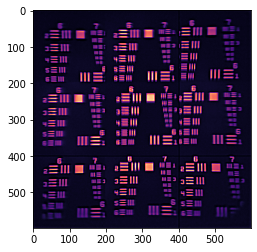

In [19]:
# Your custom regularization parameters
l2_reg_value = 1e-5
tv_reg_value = 1e-8

# Call ring_deconvolve with custom parameters
rd_recon = rdmpy.ring_deconvolve(
    measurement, 
    psf_data, 
    tv_reg=tv_reg_value, 
    l2_reg=l2_reg_value, 
    device=device
)
# Visualize the deconvolved image
plt.imshow(rd_recon[crop:-crop, crop:-crop], cmap='magma')
plt.show()

# Save the deconvolved image
io.imsave('output/ring_deconvolve_5_8.png', (255 * rd_recon).astype(np.uint8))



For a faster version, consider using `deeprd`. DeepRD only requires seidel coefficients, which can be gotted more efficiently by running calibrate with the `get_psf_data` flag set to false. But we've already gotten the coefficients, we we'll just use them directly.

In [5]:
deeprd_recon = rdmpy.deeprd(measurement, seidel_coeffs, device=device)
plt.imshow(deeprd_recon[crop:-crop,crop:-crop], cmap='magma')
plt.show()
io.imsave('output/deeprd.png', (255 * deeprd_recon).astype(np.uint8))

loading model...


NotImplementedError: DeepRD model not found for this image size

## Alternative methods

Suppose that that system is actually space-invariant; i.e., the PSF does not chance much across the field-of-view. In such a case is more sensible to use Seidel deconvoution, which we show below.

rendering PSFs...


100%|██████████| 1/1 [00:00<00:00, 17.86it/s]

Time for deconvolution: 0.00327 seconds


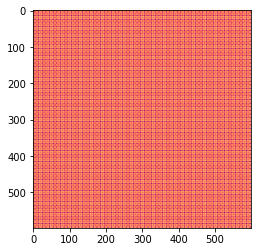

In [31]:
import time
# First we calibrate (we already have seidel coefficients from before, so we can just directly get the PSF)
center_psf = rdmpy.get_psfs(seidel_coeffs, measurement.shape[0], model='lsi', device=device)
start_time_deconv = time.time()
# Now we run standard deconvolution
deconv_recon = rdmpy.deconvolve(measurement, center_psf, method='wiener', device=device) # method wiener or iter
end_time_deconv = time.time()
print(f"Time for deconvolution: {end_time_deconv - start_time_deconv:.5f} seconds")

plt.imshow(deconv_recon[crop:-crop, crop:-crop], cmap='magma')
plt.show()
io.imsave('output/space_invariant.png', (255 * np.array(deconv_recon)).astype(np.uint8))

rendering PSFs...


  0%|          | 0/1 [00:00<?, ?it/s]

/home/alingold/rdmpy_20231220/rdmpy/_src/seidel.py:149: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  [Fx, Fy] = torch.tensor(np.meshgrid(fx, fx), device=device)
100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


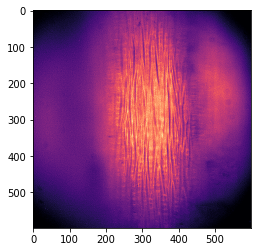

In [3]:
# Your custom regularization parameters
l2_reg_value = 1e-9 # 1e-9 default
tv_reg_value = 1e-10 # 1e-9 default
balance_value = 3e-4 # 3e-4 default

# First we calibrate (we already have seidel coefficients from before, so we can just directly get the PSF)
center_psf = rdmpy.get_psfs(seidel_coeffs, measurement.shape[0], model='lsi', device=device)

# Now we run standard deconvolution
deconv_recon = rdmpy.deconvolve(measurement, center_psf, method='wiener', tv_reg=tv_reg_value, l2_reg=l2_reg_value, balance=balance_value , device=device)

plt.imshow(deconv_recon[crop:-crop, crop:-crop], cmap='magma')
plt.show()
io.imsave('output/space_invariant_1e-9_1e-10_3e-4.png', (255 * np.array(deconv_recon)).astype(np.uint8))

Finally, suppose that calibration data (e.g., the PSF) is not available. The only option is blind Seidel deconvolution, which we show below. Note that the only thing needed for blind deconvolution is the measurement!

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 18.81it/s]

Fitted seidel coefficient: tensor([-0.4091])
Time for blind deconvolution: 5.33821 seconds


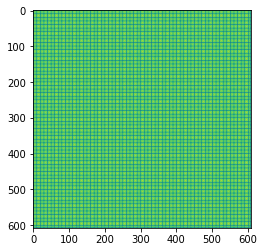

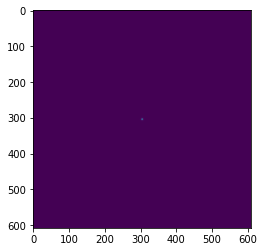

In [32]:
start_time_blind = time.time()
blind_recon = rdmpy.blind(measurement, get_psf=True, balance = 1e-3, device=device)
end_time_blind = time.time()
print(f"Time for blind deconvolution: {end_time_blind - start_time_blind:.5f} seconds")
psf = blind_recon[1]
blind_recon = blind_recon[0]

plt.imshow(blind_recon)
#plt.savefig('output/blind.png', bbox_inches='tight')
plt.show()
io.imsave('output/blind_1e-3.png', (255 * blind_recon).astype(np.uint8))

plt.imshow(psf)
#plt.savefig('output/blind.png', bbox_inches='tight')
plt.show()

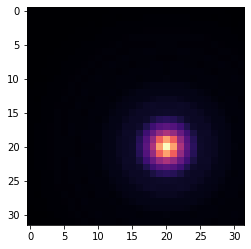

In [14]:
psf = psf[108:140, 108:140]
plt.imshow(psf, cmap='magma')
plt.savefig('output/blind.png', bbox_inches='tight')
plt.show()

(608, 608) 0.0 0.615686274509804


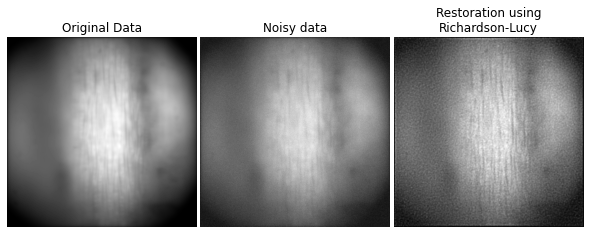

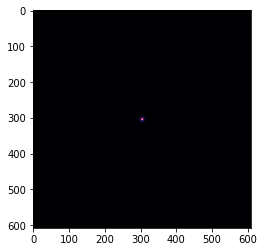

In [5]:
# Richardson Lucy deconvolution
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration

import numpy as np
from scipy.ndimage import gaussian_filter

def create_gaussian_psf(size, sigma):
    # Create a 2D grid of coordinates
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)
    
    # Calculate the 2D Gaussian function
    psf = np.exp(-(x**2 + y**2) / (2.0 * sigma**2))
    
    # Normalize the PSF so that its sum is 1
    psf /= psf.sum()
    
    return psf

# Example usage:
psf_size = 7  # for example, a 5x5 PSF
psf_sigma = 0.5  # standard deviation in pixels
#psf = create_gaussian_psf(psf_size, psf_sigma)


rng = np.random.default_rng()

astro = measurement
#astro = (astro - astro.min()) / (astro.max() - astro.min())
astro = astro / 255
#astro = color.rgb2gray(data.astronaut())
print(astro.shape, astro.min(), astro.max())
#psf = np.ones((5, 5)) / 25
astro = conv2(astro, psf, 'same')

# Add Noise to Image
astro_noisy = astro.copy()
astro_noisy += (rng.poisson(lam=25, size=astro.shape) - 10) / 255.

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(astro_noisy, psf, num_iter=30)
deconvolved_norm = (deconvolved_RL - deconvolved_RL.min()) / (deconvolved_RL.max() - deconvolved_RL.min())
deconvolved_8bit = (deconvolved_norm * 255).astype(np.uint8)

#normalize
#deconvolved_RL = (deconvolved_RL - deconvolved_RL.min()) / (deconvolved_RL.max() - deconvolved_RL.min()) * 255

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(astro)
ax[0].set_title('Original Data')
/home/alingold/rdmpy_20231220/output/20231217_USAF_Grid_20231218_beads/measurement.png
ax[1].imshow(astro_noisy)
ax[1].set_title('Noisy data')

ax[2].imshow(deconvolved_RL, vmin=astro_noisy.min(), vmax=astro_noisy.max())
ax[2].set_title('Restoration using\nRichardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()

plt.imshow(psf, cmap='magma')
plt.imsave('output/richardson_deconvolved.png', deconvolved_8bit, cmap='gray')
plt.show()

In [10]:
import os
from skimage import io, color, img_as_ubyte

def center_crop(img, des_shape, m_center=None):
    if m_center is None:
        m_center = (img.shape[0] // 2, img.shape[1] // 2)
    left, right, up, down = (
        m_center[1] - des_shape[1] // 2,
        m_center[1] + int(np.round(des_shape[1] / 2)),
        m_center[0] - des_shape[0] // 2,
        m_center[0] + int(np.round(des_shape[0] / 2)),
    )
    return img[up:down, left:right]

def process_and_save_images(image_paths):
    crop = 5
    output_dir = 'output/blind_batch'
    os.makedirs(output_dir, exist_ok=True)
    
    for idx, image_path in enumerate(image_paths):
        measurement = io.imread(image_path)
        if len(measurement.shape) > 2:
            measurement = color.rgb2gray(measurement)
            print(f'Converting {os.path.basename(image_path)} to grayscale')
        measurement = img_as_ubyte(measurement)
        
        cropped_measurement = measurement[crop:-crop, crop:-crop]
        # Save using the index from image_paths list
        io.imsave(os.path.join(output_dir, f'{idx+1}_measurement.png'), cropped_measurement)
        
        # Make sure 'device' is defined or replace it with 'cpu' or 'cuda'
        blind_recon = rdmpy.blind(cropped_measurement, balance=1e0, device='cpu')  # Example: using CPU
        # Save the reconstructed image using the index
        io.imsave(os.path.join(output_dir, f'{idx+1}_5e-1.png'), (255 * blind_recon).astype(np.uint8))

# Example usage
image_paths = [
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_cannula_only/test_latest/images/23_fake_B.png', # no 4f 1
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_cannula_only/test_latest/images/24_fake_B.png', # 2
    '/home/alingold/BCI/PyramidPix2pix/results/combined_plant_0bp_noBlurryRemoval_cannula_only/test_latest/images/23_fake_B.png', # 3
    '/home/alingold/BCI/PyramidPix2pix/results/combined_plant_0bp_noBlurryRemoval_cannula_only/test_latest/images/24_fake_B.png', # 4
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_NoGan_cannula_only/test_latest/images/23_fake_B.png', # 5
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_NoGan_cannula_only/test_latest/images/24_fake_B.png', # 6
    '/home/alingold/pix2pix/results/plant_0bp_cannula_only/test_latest/images/23_fake_B.png', # 7
    '/home/alingold/pix2pix/results/plant_0bp_cannula_only/test_latest/images/24_fake_B.png',   
    '/home/alingold/pix2pix/results/plant_cannula_only_log_confidence_mean-2.8336_std0.0131812/test_latest/images/23_fake_B.png_conf_-2.619.png', # 9
    '/home/alingold/pix2pix/results/plant_cannula_only_log_confidence_mean-2.8336_std0.0131812/test_latest/images/24_fake_B.png_conf_-2.674.png', # 10

    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest_ForEdison/test_latest/images/8845_real_B.png', # ground truth 11
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest_ForEdison/test_latest/images/8845_fake_B.png', #pix2pix 12
    '/home/alingold/BCI/PyramidPix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest/test_latest/images/8845_fake_B.png', #pyramid 13
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_NoGan_oldtest/test_latest/images/8845_fake_B.png', #no gan 14
    '/home/alingold/pix2pix/results/plant_noBlurRemoval_0bp_noMask_pix2pix_oldTest/test_latest/images/8845_fake_B.png', #no mask 15
    '/home/alingold/pix2pix/results/plant_0bp_oldtest/test_latest/images/8845_fake_B.png', #blurry removal 16   
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_resnet_oldTest/test_latest/images/8845_fake_B.png', #resnet 17
    '/home/alingold/pix2pix/results/plant_average_oldtest_ave0.4578_std0.013334/test_latest/images/8845_fake_B.png_conf_0.445.png', # mean 18

    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest_ForEdison/test_latest/images/38321_real_B.png', # 19
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest_ForEdison/test_latest/images/38321_fake_B.png', # 20
    '/home/alingold/BCI/PyramidPix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest/test_latest/images/38321_fake_B.png', # 21
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_NoGan_oldtest/test_latest/images/38321_fake_B.png',  # 22
    '/home/alingold/pix2pix/results/plant_noBlurRemoval_0bp_noMask_pix2pix_oldTest/test_latest/images/38321_fake_B.png', # 23
    '/home/alingold/pix2pix/results/plant_0bp_oldtest/test_latest/images/38321_fake_B.png', # 24
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_resnet_oldTest/test_latest/images/38321_fake_B.png', # 25
    '/home/alingold/pix2pix/results/plant_average_oldtest_ave0.4578_std0.013334/test_latest/images/38321_fake_B.png_conf_0.428.png', # 26

    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest_ForEdison/test_latest/images/59403_real_B.png', # 27
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest_ForEdison/test_latest/images/59403_fake_B.png', # 28
    '/home/alingold/BCI/PyramidPix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest/test_latest/images/59403_fake_B.png', # 29
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_NoGan_oldtest/test_latest/images/59403_fake_B.png', # 30
    '/home/alingold/pix2pix/results/plant_noBlurRemoval_0bp_noMask_pix2pix_oldTest/test_latest/images/59403_fake_B.png', # 31
    '/home/alingold/pix2pix/results/plant_0bp_oldtest/test_latest/images/59403_fake_B.png', # 32
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_resnet_oldTest/test_latest/images/59403_fake_B.png', # 33
    '/home/alingold/pix2pix/results/plant_average_oldtest_ave0.4578_std0.013334/test_latest/images/59403_fake_B.png_conf_0.438.png', # 34

    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest_ForEdison/test_latest/images/89794_real_B.png', # 35
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest_ForEdison/test_latest/images/89794_fake_B.png', # 36
    '/home/alingold/BCI/PyramidPix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest/test_latest/images/89794_fake_B.png', # 37
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_NoGan_oldtest/test_latest/images/89794_fake_B.png', # 38
    '/home/alingold/pix2pix/results/plant_noBlurRemoval_0bp_noMask_pix2pix_oldTest/test_latest/images/89794_fake_B.png', # 39
    '/home/alingold/pix2pix/results/plant_0bp_oldtest/test_latest/images/89794_fake_B.png', # 40
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_resnet_oldTest/test_latest/images/89794_fake_B.png', # 41
    '/home/alingold/pix2pix/results/plant_average_oldtest_ave0.4578_std0.013334/test_latest/images/89794_fake_B.png_conf_0.473.png', # 42

    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest_ForEdison/test_latest/images/118240_real_B.png', # 43
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest_ForEdison/test_latest/images/118240_fake_B.png', # 44
    '/home/alingold/BCI/PyramidPix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest/test_latest/images/118240_fake_B.png', # 45
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_NoGan_oldtest/test_latest/images/118240_fake_B.png', # 46
    '/home/alingold/pix2pix/results/plant_noBlurRemoval_0bp_noMask_pix2pix_oldTest/test_latest/images/118240_fake_B.png', # 47
    '/home/alingold/pix2pix/results/plant_0bp_oldtest/test_latest/images/118240_fake_B.png', # 48
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_resnet_oldTest/test_latest/images/118240_fake_B.png', # 49
    '/home/alingold/pix2pix/results/plant_average_oldtest_ave0.4578_std0.013334/test_latest/images/118240_fake_B.png_conf_0.467.png', # 50

    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_20231012_noblurry100/test_latest/images/318_real_B.png', # other branch real 51
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_20231012_noblurry100/test_latest/images/318_fake_B.png', # pix2pix 52
    '/home/alingold/BCI/PyramidPix2pix/results/combined_plant_0bp_noBlurryRemoval_20231012_noblurry100/test_latest/images/318_fake_B.png', # pyramid 53
    '/home/alingold/pix2pix/results/plant_0bp_20231012_noblurry100/test_latest/images/318_fake_B.png', # blurry removal 54
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_NoGan_20231012_noblurry100/test_latest/images/318_fake_B.png', # no gan 55
    '/home/alingold/pix2pix/results/plant_average_20231012_noblurry100_ave0.4471_std0.015061/test_latest/images/318_fake_B.png_conf_0.420.png', # mean 56

    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_20231012_noblurry100/test_latest/images/420_real_B.png', # other branch real 57
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_20231012_noblurry100/test_latest/images/420_fake_B.png', # pix2pix 58
    '/home/alingold/BCI/PyramidPix2pix/results/combined_plant_0bp_noBlurryRemoval_20231012_noblurry100/test_latest/images/420_fake_B.png', # pyramid 59
    '/home/alingold/pix2pix/results/plant_0bp_20231012_noblurry100/test_latest/images/420_fake_B.png', # blurry removal 60
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_NoGan_20231012_noblurry100/test_latest/images/420_fake_B.png', # no gan 61
    '/home/alingold/pix2pix/results/plant_average_20231012_noblurry100_ave0.4471_std0.015061/test_latest/images/420_fake_B.png_conf_0.456.png', # mean 62
    
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_0929_x3/test_latest/images/26_real_B.png', #timelapse 63
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_0929_x3/test_latest/images/26_fake_B.png', # pix2pix 64
    '/home/alingold/BCI/PyramidPix2pix/results/combined_plant_0bp_noBlurryRemoval_0929_x3/test_latest/images/26_fake_B.png', # pyramid 65
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_NoGan_0929_x3/test_latest/images/26_fake_B.png', # no gan 66
    '/home/alingold/pix2pix/results/plant_0bp_0929_x3/test_latest/images/26_fake_B.png', # blurry removal 67
    '/home/alingold/pix2pix/results/plant_0929_x3_log_confidence_mean-2.4167_std0.106209/test_latest/images/26_fake_B.png_conf_-2.628.png', # mean 68

    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_0929_x3/test_latest/images/27_real_B.png', # 69
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_0929_x3/test_latest/images/27_fake_B.png', # 70
    '/home/alingold/BCI/PyramidPix2pix/results/combined_plant_0bp_noBlurryRemoval_0929_x3/test_latest/images/27_fake_B.png', # 71
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_NoGan_0929_x3/test_latest/images/27_fake_B.png', # 72
    '/home/alingold/pix2pix/results/plant_0bp_0929_x3/test_latest/images/27_fake_B.png', # 73
    '/home/alingold/pix2pix/results/plant_0929_x3_log_confidence_mean-2.4167_std0.106209/test_latest/images/27_fake_B.png_conf_-2.575.png', # 74
    
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_0929_x3/test_latest/images/41_real_B.png', # 75
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_0929_x3/test_latest/images/41_fake_B.png', # 76
    '/home/alingold/BCI/PyramidPix2pix/results/combined_plant_0bp_noBlurryRemoval_0929_x3/test_latest/images/41_fake_B.png', # 77
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_NoGan_0929_x3/test_latest/images/41_fake_B.png', # 78
    '/home/alingold/pix2pix/results/plant_0bp_0929_x3/test_latest/images/41_fake_B.png', # 79
    '/home/alingold/pix2pix/results/plant_0929_x3_log_confidence_mean-2.4167_std0.106209/test_latest/images/41_fake_B.png_conf_-2.341.png', # 80

    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest_ForEdison/test_latest/images/70028_real_B.png', # ground truth 81 Second row of main paper fig 3
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest_ForEdison/test_latest/images/70028_fake_B.png', #pix2pix 82
    '/home/alingold/BCI/PyramidPix2pix/results/combined_plant_0bp_noBlurryRemoval_oldtest/test_latest/images/70028_fake_B.png', #pyramid 83
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_NoGan_oldtest/test_latest/images/70028_fake_B.png', #no gan 84
    '/home/alingold/pix2pix/results/plant_noBlurRemoval_0bp_noMask_pix2pix_oldTest/test_latest/images/70028_fake_B.png', #no mask 85
    '/home/alingold/pix2pix/results/plant_0bp_oldtest/test_latest/images/70028_fake_B.png', #blurry removal 86   
    '/home/alingold/pix2pix/results/combined_plant_0bp_noBlurryRemoval_resnet_oldTest/test_latest/images/70028_fake_B.png', #resnet 87
    '/home/alingold/pix2pix/results/plant_average_oldtest_ave0.4578_std0.013334/test_latest/images/70028_fake_B.png_conf_0.485.png', # mean 88
]
process_and_save_images(image_paths)


Converting 23_fake_B.png to grayscale


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 46.87it/s]


Fitted seidel coefficient: tensor([4.0030])
Converting 24_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.12it/s]


Fitted seidel coefficient: tensor([3.9302])
Converting 23_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.75it/s]


Fitted seidel coefficient: tensor([3.6061])
Converting 24_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.87it/s]


Fitted seidel coefficient: tensor([4.6513])
Converting 23_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.53it/s]


Fitted seidel coefficient: tensor([4.4065])
Converting 24_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.63it/s]


Fitted seidel coefficient: tensor([4.6014])
Converting 23_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.24it/s]


Fitted seidel coefficient: tensor([3.7592])
Converting 24_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.54it/s]


Fitted seidel coefficient: tensor([3.3963])
Converting 23_fake_B.png_conf_-2.619.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.05it/s]


Fitted seidel coefficient: tensor([3.8537])
Converting 24_fake_B.png_conf_-2.674.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.71it/s]


Fitted seidel coefficient: tensor([4.6629])
Converting 8845_real_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.16it/s]


Fitted seidel coefficient: tensor([4.2768])
Converting 8845_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.35it/s]


Fitted seidel coefficient: tensor([3.5427])
Converting 8845_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.31it/s]


Fitted seidel coefficient: tensor([3.4690])
Converting 8845_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.08it/s]


Fitted seidel coefficient: tensor([3.3689])
Converting 8845_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.39it/s]


Fitted seidel coefficient: tensor([4.2242])
Converting 8845_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.88it/s]


Fitted seidel coefficient: tensor([3.5625])
Converting 8845_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.50it/s]


Fitted seidel coefficient: tensor([4.4205])
Converting 8845_fake_B.png_conf_0.445.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.86it/s]


Fitted seidel coefficient: tensor([3.5212])
Converting 38321_real_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.91it/s]


Fitted seidel coefficient: tensor([3.2346])
Converting 38321_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.63it/s]


Fitted seidel coefficient: tensor([3.1565])
Converting 38321_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.80it/s]


Fitted seidel coefficient: tensor([3.4689])
Converting 38321_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.00it/s]


Fitted seidel coefficient: tensor([4.8092])
Converting 38321_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.20it/s]


Fitted seidel coefficient: tensor([3.7962])
Converting 38321_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.07it/s]


Fitted seidel coefficient: tensor([3.0420])
Converting 38321_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.95it/s]


Fitted seidel coefficient: tensor([4.7255])
Converting 38321_fake_B.png_conf_0.428.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.91it/s]


Fitted seidel coefficient: tensor([3.4922])
Converting 59403_real_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.28it/s]


Fitted seidel coefficient: tensor([3.4488])
Converting 59403_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.81it/s]


Fitted seidel coefficient: tensor([3.4048])
Converting 59403_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 45.62it/s]


Fitted seidel coefficient: tensor([3.2402])
Converting 59403_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.09it/s]


Fitted seidel coefficient: tensor([4.2750])
Converting 59403_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 45.91it/s]


Fitted seidel coefficient: tensor([3.8827])
Converting 59403_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.84it/s]


Fitted seidel coefficient: tensor([3.5621])
Converting 59403_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.10it/s]


Fitted seidel coefficient: tensor([4.2377])
Converting 59403_fake_B.png_conf_0.438.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.03it/s]


Fitted seidel coefficient: tensor([3.6038])
Converting 89794_real_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.12it/s]


Fitted seidel coefficient: tensor([3.6886])
Converting 89794_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.64it/s]


Fitted seidel coefficient: tensor([3.8842])
Converting 89794_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.65it/s]


Fitted seidel coefficient: tensor([4.3563])
Converting 89794_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.56it/s]


Fitted seidel coefficient: tensor([3.8066])
Converting 89794_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.19it/s]


Fitted seidel coefficient: tensor([4.1825])
Converting 89794_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.41it/s]


Fitted seidel coefficient: tensor([4.1961])
Converting 89794_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.57it/s]


Fitted seidel coefficient: tensor([4.2329])
Converting 89794_fake_B.png_conf_0.473.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.39it/s]


Fitted seidel coefficient: tensor([4.1602])
Converting 118240_real_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.29it/s]


Fitted seidel coefficient: tensor([3.6905])
Converting 118240_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.10it/s]


Fitted seidel coefficient: tensor([4.1164])
Converting 118240_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.45it/s]


Fitted seidel coefficient: tensor([3.8795])
Converting 118240_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.03it/s]


Fitted seidel coefficient: tensor([4.4560])
Converting 118240_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.92it/s]


Fitted seidel coefficient: tensor([4.8916])
Converting 118240_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.53it/s]


Fitted seidel coefficient: tensor([3.8122])
Converting 118240_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.83it/s]


Fitted seidel coefficient: tensor([4.4879])
Converting 118240_fake_B.png_conf_0.467.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.91it/s]


Fitted seidel coefficient: tensor([4.0203])
Converting 318_real_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.58it/s]


Fitted seidel coefficient: tensor([3.4785])
Converting 318_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.15it/s]


Fitted seidel coefficient: tensor([3.7772])
Converting 318_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.20it/s]


Fitted seidel coefficient: tensor([3.8171])
Converting 318_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.03it/s]


Fitted seidel coefficient: tensor([3.1288])
Converting 318_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.92it/s]


Fitted seidel coefficient: tensor([4.0303])
Converting 318_fake_B.png_conf_0.420.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.01it/s]


Fitted seidel coefficient: tensor([3.8434])
Converting 420_real_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.93it/s]


Fitted seidel coefficient: tensor([3.7133])
Converting 420_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.27it/s]


Fitted seidel coefficient: tensor([4.3570])
Converting 420_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.65it/s]


Fitted seidel coefficient: tensor([4.5084])
Converting 420_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.19it/s]


Fitted seidel coefficient: tensor([4.1019])
Converting 420_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.57it/s]


Fitted seidel coefficient: tensor([4.3437])
Converting 420_fake_B.png_conf_0.456.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.63it/s]


Fitted seidel coefficient: tensor([4.6810])
Converting 26_real_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.54it/s]


Fitted seidel coefficient: tensor([3.7144])
Converting 26_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.12it/s]


Fitted seidel coefficient: tensor([3.9119])
Converting 26_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.34it/s]


Fitted seidel coefficient: tensor([3.8744])
Converting 26_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.70it/s]


Fitted seidel coefficient: tensor([3.9543])
Converting 26_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.26it/s]


Fitted seidel coefficient: tensor([3.8707])
Converting 26_fake_B.png_conf_-2.628.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 45.53it/s]


Fitted seidel coefficient: tensor([3.5663])
Converting 27_real_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.29it/s]


Fitted seidel coefficient: tensor([3.4010])
Converting 27_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.80it/s]


Fitted seidel coefficient: tensor([4.2735])
Converting 27_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.19it/s]


Fitted seidel coefficient: tensor([4.2284])
Converting 27_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.07it/s]


Fitted seidel coefficient: tensor([3.9312])
Converting 27_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.53it/s]


Fitted seidel coefficient: tensor([4.1467])
Converting 27_fake_B.png_conf_-2.575.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.91it/s]


Fitted seidel coefficient: tensor([4.3166])
Converting 41_real_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.51it/s]


Fitted seidel coefficient: tensor([3.7560])
Converting 41_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.19it/s]


Fitted seidel coefficient: tensor([4.8098])
Converting 41_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 45.79it/s]


Fitted seidel coefficient: tensor([4.3583])
Converting 41_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 47.02it/s]


Fitted seidel coefficient: tensor([5.4916])
Converting 41_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.85it/s]


Fitted seidel coefficient: tensor([4.6967])
Converting 41_fake_B.png_conf_-2.341.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.77it/s]


Fitted seidel coefficient: tensor([5.2343])
Converting 70028_real_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.69it/s]


Fitted seidel coefficient: tensor([3.7025])
Converting 70028_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.27it/s]


Fitted seidel coefficient: tensor([4.0557])
Converting 70028_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.55it/s]


Fitted seidel coefficient: tensor([4.8546])
Converting 70028_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 42.90it/s]


Fitted seidel coefficient: tensor([4.4777])
Converting 70028_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 41.13it/s]


Fitted seidel coefficient: tensor([4.1251])
Converting 70028_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 36.55it/s]


Fitted seidel coefficient: tensor([4.4092])
Converting 70028_fake_B.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 44.99it/s]


Fitted seidel coefficient: tensor([4.8267])
Converting 70028_fake_B.png_conf_0.485.png to grayscale


100%|██████████| 100/100 [00:02<00:00, 46.61it/s]

Fitted seidel coefficient: tensor([4.7752])
